# Multi-class classification using gene expression
# Gradient booster decision trees

In [1]:
if (!require(xgboost, quietly=TRUE)) {install.packages('xgboost', repos='http://cran.us.r-project.org')}
if (!require(ggplot2, quietly=TRUE)) {install.packages('ggplot2', repos='http://cran.us.r-project.org')}
if (!require(tidyr, quietly=TRUE)) {install.packages('tidyr', repos='http://cran.us.r-project.org')}
if (!require(Ckmeans.1d.dp, quietly=TRUE)) {install.packages('Ckmeans.1d.dp', repos='http://cran.us.r-project.org')}

In [2]:
if (!exists("big12vxg_vsn")) {
    load("/users/rdonovan/shared_data/allen_brain_big12annotation_vsn.Rdata")
}

In [3]:
levels(big12factors)

[1] "Cerebellum"              "Cerebral cortex"        
 [3] "Hippocampal region"      "Hypothalamus"           
 [5] "Medulla"                 "Midbrain"               
 [7] "Olfactory areas"         "Pallidum"               
 [9] "Pons"                    "Retrohippocampal region"
[11] "Striatum"                "Thalamus"

In [4]:
# data_inds <- (big12factors == 'Cerebellum') | (big12factors == 'Striatum') | (big12factors == 'Thalamus')
data_inds <- TRUE #  all 12 regions
X <- big12vxg_vsn[data_inds,]
y <- factor(big12factors[data_inds])

# convert labels to ints for xgboost
y_int <- y
levels(y_int) <- as.character(1:length(levels(y)) - 1)
y_int <- as.numeric(levels(y_int))[y_int]

N_samples <- length(y_int)

print(dim(X))
print(N_samples)
print(head(colnames(X)))
table(y_int)

[1] 23996  3041
[1] 23996
[1] "Acadl"  "Acadvl" "Accn1"  "Ace"    "Ache"   "Chrna1"


y_int
   0    1    2    3    4    5    6    7    8    9   10   11 
2886 7429 1072  872 1550 1969 2310  489 1161 1002 2170 1086 

In [5]:
p = 0.75
test_train_inds <- sample(1:N_samples, N_samples*p, replace = FALSE)

X_test_train <- X[test_train_inds,]
y_test_train <- y_int[test_train_inds]
X_holdout <- X[-test_train_inds,]
y_holdout <- y_int[-test_train_inds]

In [26]:
param <- list("objective" = "multi:softmax",
              "num_class" = 12,
              "max.depth" = 5,
              "eta" = 0.05
              )

In [27]:
# gbdt.cv <- xgb.cv(
#     params = param,
#     nfold = 5,
#     data = X_test_train,
#     label = y_test_train,
#     nround = 100,
#     verbose = FALSE,
#     nthread = 16
# )
# tail(gbdt.cv)

In [ ]:
gbdt <- xgboost(
    params = param,
    data = X_test_train,
    label = y_test_train,
    nround = 100,
    verbose = FALSE,
    nthread = 12
)

In [11]:
preds <- predict(gbdt, X_holdout)

In [12]:
fraction_correct <- mean(round(preds) == y_holdout)
fraction_correct

[1] 0.9431572

In [13]:
importance_matrix <- xgb.importance(colnames(X),model=gbdt)
top_genes_info <- head(importance_matrix,50)

In [15]:
head(top_genes_info)

,Feature,Gain,Cover,Frequence
1,Satb2,0.178371864224704,0.00969011303691626,0.00278551532033426
2,3110001A13Rik,0.105612799969597,0.00969011303691626,0.00278551532033426
3,Strn,0.0636396120959151,0.00969011303691626,0.00278551532033426
4,Glra1,0.0477440402185635,0.0406116755835555,0.0167130919220056
5,Alkbh6,0.0394795987553389,0.00969011303691626,0.00278551532033426
6,1810041L15Rik,0.0337310004674148,0.0141763639339656,0.00557103064066852


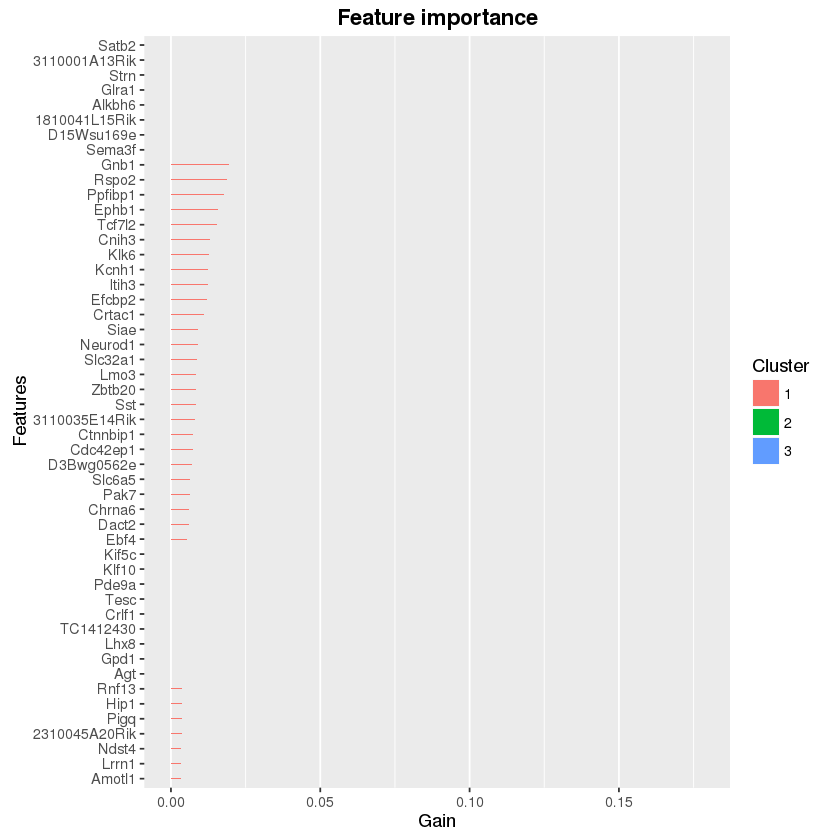

In [25]:
xgb.plot.importance(top_genes_info)

In [16]:
top_degs <- (importance_matrix)$Feature[1:6]
top_degs

[1] "Satb2"         "3110001A13Rik" "Strn"          "Glra1"        
[5] "Alkbh6"        "1810041L15Rik"

In [17]:
deg_df <- cbind(Region=y,data.frame(X[,top_degs]))
dim(deg_df)

[1] 23996     7

In [19]:
deg_df <- cbind(Region=y,data.frame(X[,top_degs]))
deg_df_tidy <- gather(deg_df, 'Gene', 'Expression', -Region)

In [20]:
p <- ggplot(deg_df_tidy) + 
    theme_minimal() + 
    theme(legend.position = "bottom")

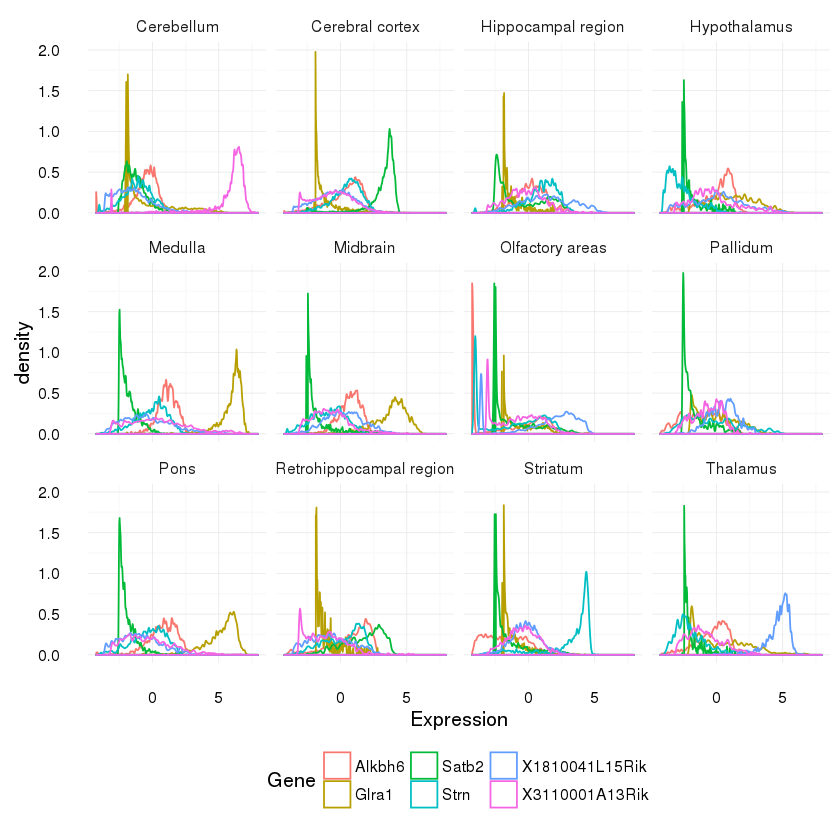

In [21]:
p2 <- p + 
    geom_density(aes(Expression, colour = Gene), adjust = 0.2) + 
    facet_wrap(~ Region) + ylim(0,2)
p2